In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import seaborn as sns

In [2]:
flights_fe = pd.read_csv(r"../data/sample_with_inbound_data.csv")

In [3]:
data = pd.read_csv(r"../data/faa_airport_details.csv")
data = data.set_index("airport_code")

In [4]:
flights_fe.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,longest_add_gtime,no_name,arr_date_time,dep_date_time,arr_month,origin_airport_type,dest_airport_type,arr_day_of_week,arr_hour,inbound_flights
0,2019-01-02,DL,DL_CODESHARE,DL,5303,9E,N606LR,5303,10397,ATL,...,NaN,NaN,2019-01-02 17:14:00,2019-01-02 15:13:00,1,Very Large,Large,2,17,4
1,2019-01-25,DL,DL_CODESHARE,DL,5443,9E,N905XJ,5443,10397,ATL,...,NaN,NaN,2019-01-25 17:18:00,2019-01-25 15:12:00,1,Very Large,Large,4,17,6
2,2019-01-03,DL,DL_CODESHARE,DL,5187,9E,N195PQ,5187,10397,ATL,...,NaN,NaN,2019-01-03 23:35:00,2019-01-03 21:30:00,1,Very Large,Large,3,23,4
3,2019-01-17,DL,DL_CODESHARE,DL,5443,9E,N310PQ,5443,10397,ATL,...,NaN,NaN,2019-01-17 17:18:00,2019-01-17 15:12:00,1,Very Large,Large,3,17,7
4,2019-01-29,DL,DL_CODESHARE,DL,5023,9E,N8928A,5023,10397,ATL,...,NaN,NaN,2019-01-29 14:45:00,2019-01-29 13:50:00,1,Very Large,Medium,1,14,12


<AxesSubplot:ylabel='arr_delay'>

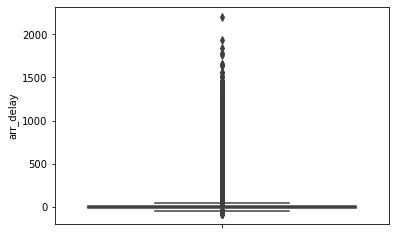

In [63]:
sns.boxplot(y=flights_fe.arr_delay)

In [6]:
flights_fe = flights_fe.astype({'dep_date_time':'datetime64[ns]','arr_date_time':'datetime64[ns]'})

In [7]:
data = data.drop(columns=['site_id', 'npias_no','airport_status','lat', 'lon', 'city', 'county',
                         'variation',
       'last_inspection_date','operations_annual_ending','elevation','air_carrier_annual'])

In [8]:
data.head()

,service_level,hub_type,ownership_status,facility_use,area,fss_on_airport,beacon_color,total_operations_annual
airport_code,,,,,,,,
HRL,Primary,Non-Hub,PUBLIC,PUBLIC,2428.0,NO,Clear and Green,41927
MOT,Primary,Non-Hub,PUBLIC,PUBLIC,1563.0,NO,Clear and Green,34586
IAH,Primary,Large,PUBLIC,PUBLIC,10000.0,NO,Clear and Green,251255
ROW,Primary,Non-Hub,PUBLIC,PUBLIC,5029.0,NO,Clear and Green,30005
PVD,Primary,Small,PUBLIC,PUBLIC,1111.0,NO,Clear and Green,72410


<AxesSubplot:>

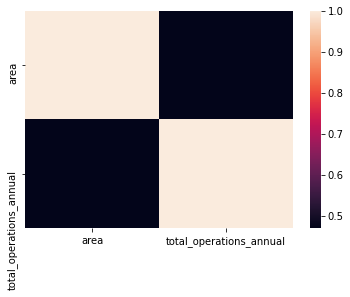

In [9]:
sns.heatmap(data.corr())

## Preprocessing

In [91]:
flights_dropped = flights_fe.copy()

In [92]:
test_columns = ["mkt_unique_carrier","branded_code_share",
               "mkt_carrier","mkt_carrier_fl_num",
               "op_unique_carrier","tail_num","op_carrier_fl_num",
               "origin_airport_id","origin","origin_city_name",
               "dest_airport_id","dest","dest_city_name","crs_elapsed_time",
               "flights","distance","arr_delay","arr_date_time","dep_date_time"]

features_engineered = ["inbound_flights"]



columns_to_drop = set(flights_dropped.columns).difference(set(test_columns+features_engineered))
flights_dropped = flights_dropped.drop(columns=columns_to_drop)

In [93]:
repetitive_columns = ["branded_code_share","mkt_carrier","tail_num","mkt_carrier_fl_num",
                      "origin_airport_id","dest_airport_id","flights"]
flights_dropped = flights_dropped.drop(columns=repetitive_columns)

In [94]:
flights_dropped  = flights_dropped.drop(columns=["arr_date_time","dep_date_time"])
flights_dropped.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,arr_delay,crs_elapsed_time,distance,inbound_flights
0,DL,9E,5303,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-17.0,121.0,692.0,4
1,DL,9E,5443,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-13.0,126.0,692.0,6
2,DL,9E,5187,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-17.0,125.0,692.0,4
3,DL,9E,5443,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-8.0,126.0,692.0,7
4,DL,9E,5023,ATL,"Atlanta, GA",AEX,"Alexandria, LA",NaN,115.0,500.0,12


In [95]:
flights_or = pd.merge(left=flights_dropped,right=data,right_index=True,left_on='origin')

In [96]:
flights_dest = pd.merge(left=flights_or,right=data,right_index=True,left_on='dest',suffixes=("_or","_des"))

In [97]:
flights_dest["origin_state"] = flights_dest.origin_city_name.map(lambda x: x.split(", ")[1])
flights_dest["dest_state"] = flights_dest.dest_city_name.map(lambda x: x.split(", ")[1])

In [98]:
flights_dest = flights_dest.drop(columns=["dest_city_name","dest","origin","origin_city_name"])
flights_dest.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,arr_delay,crs_elapsed_time,distance,inbound_flights,service_level_or,hub_type_or,ownership_status_or,...,service_level_des,hub_type_des,ownership_status_des,facility_use_des,area_des,fss_on_airport_des,beacon_color_des,total_operations_annual_des,origin_state,dest_state
0,DL,9E,5303,-17.0,121.0,692.0,4,Primary,Large,PUBLIC,...,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,GA,PA
1,DL,9E,5443,-13.0,126.0,692.0,6,Primary,Large,PUBLIC,...,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,GA,PA
2,DL,9E,5187,-17.0,125.0,692.0,4,Primary,Large,PUBLIC,...,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,GA,PA
3,DL,9E,5443,-8.0,126.0,692.0,7,Primary,Large,PUBLIC,...,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,GA,PA
2017,DL,9E,5454,26.0,123.0,692.0,9,Primary,Large,PUBLIC,...,Primary,Non-Hub,PUBLIC,PUBLIC,2278.0,NO,Clear and Green,87505,GA,PA


In [99]:
flights_dropped = flights_dest.replace({"":np.nan})

In [100]:
flights_dropped.isna().sum()

mkt_unique_carrier                 0
op_unique_carrier                  0
op_carrier_fl_num                  0
arr_delay                      16037
crs_elapsed_time                   2
distance                           0
inbound_flights                    0
service_level_or                   0
hub_type_or                      220
ownership_status_or                0
facility_use_or                    0
area_or                          937
fss_on_airport_or                  0
beacon_color_or                  160
total_operations_annual_or         0
service_level_des                  0
hub_type_des                     197
ownership_status_des               0
facility_use_des                   0
area_des                         915
fss_on_airport_des                 0
beacon_color_des                 131
total_operations_annual_des        0
origin_state                       0
dest_state                         0
dtype: int64

In [101]:
flights_dropped = flights_dropped.dropna()

In [102]:
# Import stats from scipy library
from scipy import stats
  
# Interquartile range (IQR)
IQR = stats.iqr(flights_dropped.arr_delay, interpolation = 'midpoint')

# First quartile (Q1)
Q1 = np.percentile(flights_dropped.arr_delay, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(flights_dropped.arr_delay, 75, interpolation = 'midpoint')
  
print(IQR)

23.0


In [103]:
flights_dropped = flights_dropped[(flights_dropped.arr_delay<(Q3 + 1.5*IQR)) & (flights_dropped.arr_delay>(Q1 - 1.5*IQR))]

In [104]:
flights_dropped.shape

(662128, 25)

## Modelling

In [105]:
X,y = flights_dropped.drop(columns=["arr_delay"]), flights_dropped["arr_delay"]

In [106]:
X_dummy = X.drop(columns=["op_carrier_fl_num","crs_elapsed_time"])

In [107]:
X_dummy.iloc[0]

mkt_unique_carrier                          DL
op_unique_carrier                           9E
distance                                 692.0
inbound_flights                              4
service_level_or                       Primary
hub_type_or                              Large
ownership_status_or                     PUBLIC
facility_use_or                         PUBLIC
area_or                                 4700.0
fss_on_airport_or                           NO
beacon_color_or                Clear and Green
total_operations_annual_or              525305
service_level_des                      Primary
hub_type_des                           Non-Hub
ownership_status_des                    PUBLIC
facility_use_des                        PUBLIC
area_des                                2278.0
fss_on_airport_des                          NO
beacon_color_des               Clear and Green
total_operations_annual_des              87505
origin_state                                GA
dest_state   

In [108]:
X_dummy = pd.get_dummies(
    data=X_dummy,columns=["mkt_unique_carrier","op_unique_carrier",
                        "service_level_or","hub_type_or","fss_on_airport_or","beacon_color_or",
                          "ownership_status_or","facility_use_or",
                        "service_level_des","hub_type_des","fss_on_airport_des","beacon_color_des",
                          "ownership_status_des","facility_use_des",
                        "origin_state","dest_state"])
X_dummy.shape

(662128, 169)

<AxesSubplot:ylabel='arr_delay'>

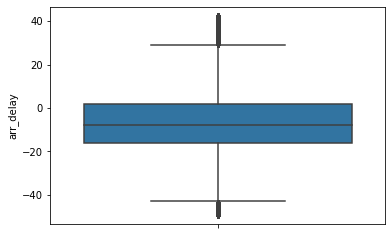

In [109]:
sns.boxplot(y=y)

In [110]:
np.mean(y)

-5.722570258318633

In [111]:
np.median(y)

-8.0

In [112]:
y[y>Q3 + 1.5*IQR]

Series([], Name: arr_delay, dtype: float64)

In [113]:
y.shape

(662128,)

In [114]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [115]:
X_train,X_test,y_train,y_test = train_test_split(X_dummy,y,train_size=0.7,random_state=1234)

In [116]:
reg = LinearRegression()
model = GridSearchCV(reg,param_grid={})
model.fit(X_train,y_train)

GridSearchCV(estimator=LinearRegression(), param_grid={})

In [117]:
y_pred = model.predict(X_test)

In [118]:
print(r2_score(y_test,y_pred))

0.02146055239387845


In [348]:
from sklearn.ensemble import RandomForestRegressor

In [349]:
reg = RandomForestRegressor(n_estimators=100)
model = GridSearchCV(reg,param_grid={})
model.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), param_grid={})

In [350]:
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

-0.012584131383346797
